# Import libraries

In [1]:
import gpytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

import random
import os
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from layers.gaussian_process import PGLikelihood, SVGP_Model

# Split dataset

In [2]:
def split_dataset_for_multilabel(X, multi_y, test_size=0.15, val_size=0.25, random_state=42, num_classes=6):
    if test_size > 0:
        # First split: train + test
        msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(msss.split(X, multi_y))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = multi_y[train_idx], multi_y[test_idx]

        # Second split: train + validation
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X_train, y_train))

        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]

    else:
        # Only split into train and validation if test_size is 0
        msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(msss_val.split(X, multi_y))

        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = multi_y[train_idx], multi_y[val_idx]
        X_test, y_test = None, None

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test


def split_data(X, y, test_size=0.15, val_size=0.15, random_state=42, num_classes=1, pos_label=0):
    if test_size > 0:
        # First split: train + test
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        train_idx, test_idx = next(sss.split(X, y[:, pos_label]))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Second split: train + validation
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X_train, y_train[:, pos_label]))

        X_train_final, X_val = X_train[train_idx], X_train[val_idx]
        y_train_final, y_val = y_train[train_idx], y_train[val_idx]
    else:
        # Only split into train and validation if test_size is 0
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss_val.split(X, y[:, pos_label]))

        X_train_final, X_val = X[train_idx], X[val_idx]
        y_train_final, y_val = y[train_idx], y[val_idx]
        X_test, y_test = None, None

    return X_train_final, y_train_final, X_val, y_val, X_test, y_test

# Attention

In [3]:
from layers.attention import MILAttentionLayer, GatedAttention

# Model

In [4]:
# Define the SVGP_MIL Model
class SVGP_MIL(nn.Module):
    def __init__(self, feature_dim, hidden_dim, output_dim, Xtrain, BagLabels, num_ind=50, verbose=False):
        super(SVGP_MIL, self).__init__()

        self.dropout = nn.Dropout(0.25)
        self.gp_layer = nn.ModuleList([SVGP_Model(torch.rand(num_ind, 1)) for _ in range(NUM_CLASSES)])

        self.fc = nn.Linear(feature_dim + 1, 1)  # Fully connected layer
        self.att_layer = nn.ModuleList([MILAttentionLayer(feature_dim, hidden_dim) for _ in range(NUM_CLASSES)])
        self.fc_gp = nn.Linear(feature_dim, 1)

    def forward(self, x):
        output = []
        gp_output = []
        for i in range(NUM_CLASSES):
            attended_features, _ = self.att_layer[i](x)
            attended_features = self.dropout(attended_features)
            gp = self.gp_layer[i](self.fc_gp(attended_features))
            gp_output.append(gp)
            combine_feature = torch.cat([attended_features, gp.mean.unsqueeze(-1)], dim=-1)
            combine_feature = self.fc(combine_feature)
            output.append(combine_feature)
        output = torch.cat(output, dim=-1)

        return output, gp_output, _

# Dataset and DataLoader

In [5]:
# Define a custom Dataset
class MedicalDataset(Dataset):
    def __init__(self, features, multi_labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.multi_labels = torch.tensor(multi_labels, dtype=torch.float32)
        print(f'Shape of multi_labels: {self.multi_labels.shape}')
        self.labels = self.multi_labels[:, 0]

    def __len__(self):
        return len(self.multi_labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx], self.multi_labels[idx]

def load_data(csv_file, num_instances=57, test_size=0.2, random_state=42, dataset='rsna'):
    df = pd.read_csv(csv_file)

    # Group features by bag_name
    grouped = df.groupby('bag_name')
    # grouped = df.groupby('bag_id')

    # Prepare feature lists and label lists
    feature_list = []
    bag_label_list = []
    multi_label_list = []
    if dataset == 'cq500':
        multi_label_names = ['patient_ICH', 'patient_EDH', 'patient_IPH', 'patient_IVH', 'patient_SAH', 'patient_SDH']
    else:
        multi_label_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
    # multi_label_names =['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']

    for bag_name, group in grouped:
        # Extract features for the current bag
        feature_cols = [f'feature_{i}' for i in range(8)]
        features = group[feature_cols].values

        # Pad with zeros if the number of instances is less than num_instances
        if len(features) < num_instances:
            padding_size = num_instances - len(features)
            padding = np.zeros((padding_size, 8))
            features = np.vstack((features, padding))  # Vertically stack features and padding

        # Truncate if the number of instances is greater than num_instances
        elif len(features) > num_instances:
            features = features[:num_instances]

        feature_list.append(features)

        # Get the bag label for the current bag
        bag_label = group['bag_label'].values[0]
        # bag_label = group['patient_label'].values[0]
        bag_label_list.append(bag_label)

        # Process multi-labels
        multi_labels = []
        for label in multi_label_names:
            # If any instance in the bag has the label, set it to 1
            label_value = 1 if (group[label] == 1).any() else 0
            multi_labels.append(label_value)
        multi_label_list.append(multi_labels)

    # Convert to numpy arrays
    X = np.array(feature_list)
    y = np.array(bag_label_list)
    multi_y = np.array(multi_label_list)

    return X, y, multi_y

# Metrics

In [6]:
def calculate_metrics(y_true, y_pred, phase='val'):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if NUM_CLASSES == 1:
        # average = 'weighted' if phase == 'train' else 'binary'
        average = 'binary' if phase == 'test' else 'weighted'
        accuracy = accuracy_score(y_true, y_pred)
    else:
        average = None
        accuracy = np.mean((y_true == y_pred).mean(axis=0))

    precision = precision_score(y_true, y_pred, average=average, zero_division=np.nan)
    recall = recall_score(y_true, y_pred, average=average, zero_division=np.nan)
    f1 = f1_score(y_true, y_pred, average=average, zero_division=np.nan)

    if phase == 'test' and NUM_CLASSES != 1:
        print(f'Precision: {precision} Recall: {recall} F1: {f1}')
        return { 'partial_accuracy': np.average(accuracy), 'precision': np.average(precision), 'recall': np.average(recall), 'f1': np.average(f1) }

    metrics = {
        'partial_accuracy': accuracy,
        'precision': np.average(precision),
        'recall': np.average(recall),
        'f1': np.average(f1)
    }
    return metrics

# Training and evaluation

In [7]:
def train(model, dataloader, optimizer, criterion, device, likelihood, var_optimizer, mlls, num_classes, threshold, use_likelihood=False):
    model.train()
    likelihood.train()
    epoch_loss = 0
    all_labels, all_preds = [], []

    with gpytorch.settings.num_likelihood_samples(100):
        for features, labels, multi_labels in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            optimizer.zero_grad()
            for opt in var_optimizer:
                opt.zero_grad()

            predictions, gp_output, _ = model(features)
            loss = calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes)

            loss.backward()
            optimizer.step()
            for opt in var_optimizer:
                opt.step()

            epoch_loss += loss.item()
            probs = get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood)
            preds = (probs >= threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(multi_labels.cpu().numpy() if num_classes > 1 else labels.cpu().numpy())

    metrics = calculate_metrics(all_labels, all_preds)
    return epoch_loss / len(dataloader), metrics['partial_accuracy'], metrics['precision'], metrics['recall'], metrics['f1']

def evaluate(model, dataloader, criterion, device, likelihood, mlls, num_classes, threshold, use_likelihood=False, phase='val'):
    model.eval()
    likelihood.eval()
    epoch_loss = 0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for features, labels, multi_labels in dataloader:
            features, labels, multi_labels = features.to(device), labels.to(device), multi_labels.to(device)

            predictions, gp_output, _ = model(features)
            loss = calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes)

            epoch_loss += loss.item()
            probs = get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood)
            preds = (probs >= threshold).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(multi_labels.cpu().numpy() if num_classes > 1 else labels.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())

    metrics = calculate_metrics(all_labels, all_preds, phase=phase)
    cohen_kappa = cohen_kappa_score(all_labels, all_preds) if num_classes == 1 else 0

    return (epoch_loss / len(dataloader), metrics['partial_accuracy'], metrics['precision'],
            metrics['recall'], metrics['f1'], cohen_kappa, all_labels, all_scores)

def get_probabilities(predictions, gp_output, likelihood, num_classes, use_likelihood):
    if use_likelihood:
        return torch.stack([likelihood[i](gp_output[i]).probs for i in range(num_classes)], dim=-1)
    else:
        return torch.sigmoid(predictions)

def calculate_loss(gp_output, multi_labels, predictions, criterion, mlls, num_classes):
    gp_loss = sum(-mll(gp, multi_labels[:, i]) for i, (mll, gp) in enumerate(zip(mlls, gp_output)))
    gp_loss = gp_loss.mean() / num_classes

    pred_loss = (criterion(predictions.squeeze(-1), multi_labels[:, 0]) if num_classes == 1
                 else criterion(predictions, multi_labels))
    total_loss = 0.5 * gp_loss + 0.5 * pred_loss
    total_loss = total_loss.mean()
    return total_loss

# Visualization

In [8]:
def plot_roc_auc(y_true, y_scores, class_names=None):
    plt.figure(figsize=(10, 8))

    if class_names is None:  # Binary classification
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
        roc_auc_values = [roc_auc]
    else:  # Multi-label classification
        roc_auc_values = []
        for i, class_name in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')
            roc_auc_values.append(roc_auc)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc_values

def plot_pr_curve(y_true, y_scores, class_names=None):
    plt.figure(figsize=(10, 8))

    if class_names is None:  # Binary classification
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        auc_pr = auc(recall, precision)
        plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.4f}')
        auc_pr_values = [auc_pr]
    else:  # Multi-label classification
        auc_pr_values = []
        for i, class_name in enumerate(class_names):
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
            auc_pr = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC = {auc_pr:.2f})')
            auc_pr_values.append(auc_pr)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return auc_pr_values

def plot_confusion_matrix(y_true, y_pred, class_names=None, threshold=0.5):
    if class_names is None:  # Binary classification
        y_pred_binary = (y_pred >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred_binary)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
    else:  # Multi-label classification
        n_classes = len(class_names)
        fig, axes = plt.subplots(2, 3, figsize=(20, 15))
        axes = axes.ravel()

        for i in range(n_classes):
            cm = confusion_matrix(y_true[:, i], (y_pred[:, i] >= threshold).astype(int))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_xlabel('Predicted labels')
            axes[i].set_ylabel('True labels')
            axes[i].set_title(f'Confusion Matrix - {class_names[i]}')

        plt.tight_layout()

    plt.show()

# Set up

In [9]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def setup_data_loaders(X_train, y_train, X_val, y_val, X_test, y_multi_test, batch_size):
    train_dataset = MedicalDataset(X_train, y_train)
    val_dataset = MedicalDataset(X_val, y_val)
    test_dataset = MedicalDataset(X_test, y_multi_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def setup_model_and_optimizer(feature_dim, hidden_dim, output_dim, X_train, y_train, device, learning_rate, num_classes):
    model = SVGP_MIL(feature_dim, hidden_dim, output_dim, X_train, y_train).to(device)
    likelihood = nn.ModuleList([PGLikelihood().to(device) for _ in range(num_classes)])
    mlls = nn.ModuleList([gpytorch.mlls.VariationalELBO(likelihood[i], model.gp_layer[i], num_data=len(X_train)) for i in range(num_classes)])
    mlls = [mll.to(device) for mll in mlls]
    variational_ngd_optim = [gpytorch.optim.NGD(model.gp_layer[i].variational_parameters(), num_data=len(X_train), lr=0.01) for i in range(num_classes)]
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(f'Len of X_train: {len(X_train)}')

    return model, likelihood, mlls, variational_ngd_optim, optimizer

# Main function

In [10]:
def main(train_file, test_file, hidden_dim=64, learning_rate=0.00005, batch_size=16, num_epochs=100, num_instances=57, use_likelihood=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load and prepare data
    X_train, y_train, y_multi_train = load_data(train_file, num_instances=num_instances)
    num_instances_for_test = 32 if 'cq500' in test_file else num_instances
    dataset = 'cq500' if 'cq500' in test_file else 'rsna'
    X_test, y_test, y_multi_test = load_data(test_file, num_instances=num_instances_for_test, dataset=dataset)

    split_func = split_dataset_for_multilabel if NUM_CLASSES > 1 else split_data
    X_train, y_train, X_val, y_val, _, _ = split_func(X_train, y_multi_train, test_size=0.0, val_size=0.25, random_state=42, num_classes=NUM_CLASSES)
    # Setup data loaders
    train_loader, val_loader, test_loader = setup_data_loaders(X_train, y_train, X_val, y_val, X_test, y_multi_test, batch_size)

    # Setup model and optimizer
    feature_dim = X_train.shape[2]
    output_dim = 1
    model, likelihood, mlls, variational_ngd_optim, optimizer = setup_model_and_optimizer(feature_dim, hidden_dim, output_dim, X_train, y_train, device, learning_rate, NUM_CLASSES)

    # Setup loss function
    pos_weights = torch.tensor([2.0] * NUM_CLASSES if NUM_CLASSES > 1 else [2.0], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    # Training loop
    best_acc = 0
    best_model = None
    best_likelihood = None
    print("Starting training...")
    for epoch in range(num_epochs):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train(model, train_loader, optimizer, criterion, device, likelihood, variational_ngd_optim,mlls, NUM_CLASSES, threshold=0.5, use_likelihood=use_likelihood)
        val_loss, val_acc, val_precision, val_recall, val_f1, val_co_kappa, val_labels, val_scores = evaluate(model, val_loader, criterion, device, likelihood, mlls, NUM_CLASSES, THRESHOLD, phase='val', use_likelihood=use_likelihood)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Precision={train_precision:.4f}, Recall={train_recall:.4f}, F1={train_f1:.4f}')
        print(f'Validation: Loss={val_loss:.4f}, Acc={val_acc:.4f}, Precision={val_precision:.4f}, Recall={val_recall:.4f}, F1={val_f1:.4f}\n')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()
            best_likelihood = likelihood.state_dict()

    print(f'Best val accuracy: {best_acc:.4f}')
    model.load_state_dict(best_model)
    likelihood.load_state_dict(best_likelihood)

    # Evaluate on test set
    test_loss, test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_labels, test_scores = evaluate(model, test_loader, criterion, device, likelihood, mlls, NUM_CLASSES, THRESHOLD, phase='test', use_likelihood=use_likelihood)
    print(f'Test: Loss={test_loss:.4f}, Acc={test_acc:.4f}, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1={test_f1:.4f}, Cohen Kappa={test_co_kappa:.4f}')

    # Plot performance curves
    if NUM_CLASSES == 1:
        test_labels, test_scores = np.array(test_labels), np.array(test_scores)
        test_auc = plot_roc_auc(test_labels, test_scores)
        test_auc_pr = plot_pr_curve(test_labels, test_scores)
        plot_confusion_matrix(test_labels, test_scores)
    else:
        class_names = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
        test_labels, test_scores = np.array(test_labels), np.array(test_scores)
        test_auc = plot_roc_auc(test_labels, test_scores, class_names)
        test_auc_pr = plot_pr_curve(test_labels, test_scores, class_names)
        plot_confusion_matrix(test_labels, test_scores, class_names)

    return test_acc, test_precision, test_recall, test_f1, test_co_kappa, test_auc, test_auc_pr

# Main

Shape of multi_labels: torch.Size([750, 6])
Shape of multi_labels: torch.Size([250, 6])
Shape of multi_labels: torch.Size([150, 6])
Len of X_train: 750
Starting training...
Epoch 1/100:
Train: Loss=0.4556, Acc=0.6600, Precision=0.6860, Recall=0.6600, F1=0.6624
Validation: Loss=0.3449, Acc=0.9240, Precision=0.9246, Recall=0.9240, F1=0.9242

Epoch 2/100:
Train: Loss=0.4183, Acc=0.7253, Precision=0.7447, Recall=0.7253, F1=0.7276
Validation: Loss=0.3027, Acc=0.9280, Precision=0.9283, Recall=0.9280, F1=0.9281

Epoch 3/100:
Train: Loss=0.4089, Acc=0.7213, Precision=0.7531, Recall=0.7213, F1=0.7229
Validation: Loss=0.2783, Acc=0.9400, Precision=0.9399, Recall=0.9400, F1=0.9400

Epoch 4/100:
Train: Loss=0.3947, Acc=0.7293, Precision=0.7476, Recall=0.7293, F1=0.7316
Validation: Loss=0.2550, Acc=0.9400, Precision=0.9399, Recall=0.9400, F1=0.9400

Epoch 5/100:
Train: Loss=0.4018, Acc=0.7307, Precision=0.7437, Recall=0.7307, F1=0.7329
Validation: Loss=0.2409, Acc=0.9400, Precision=0.9399, Recall=0

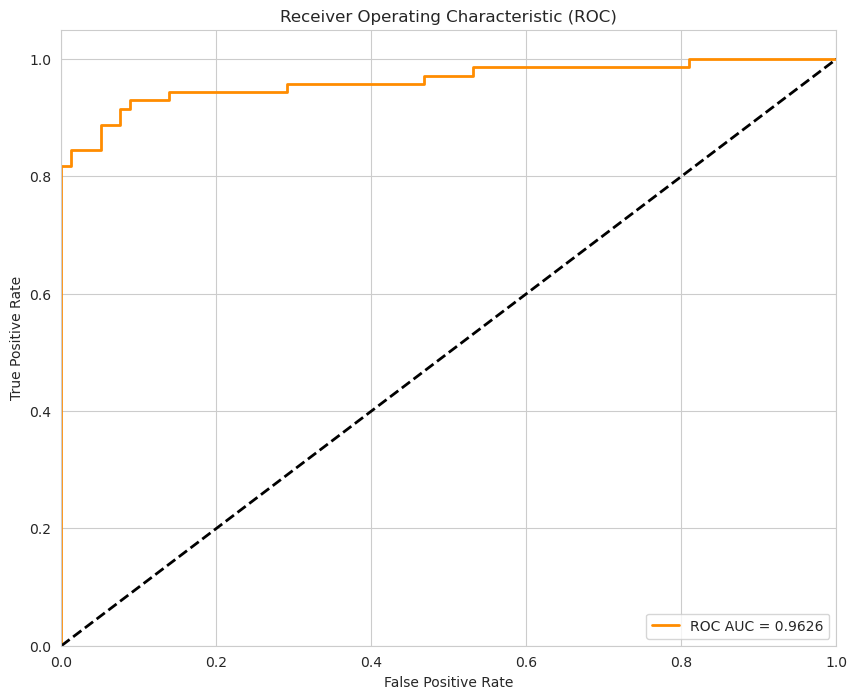

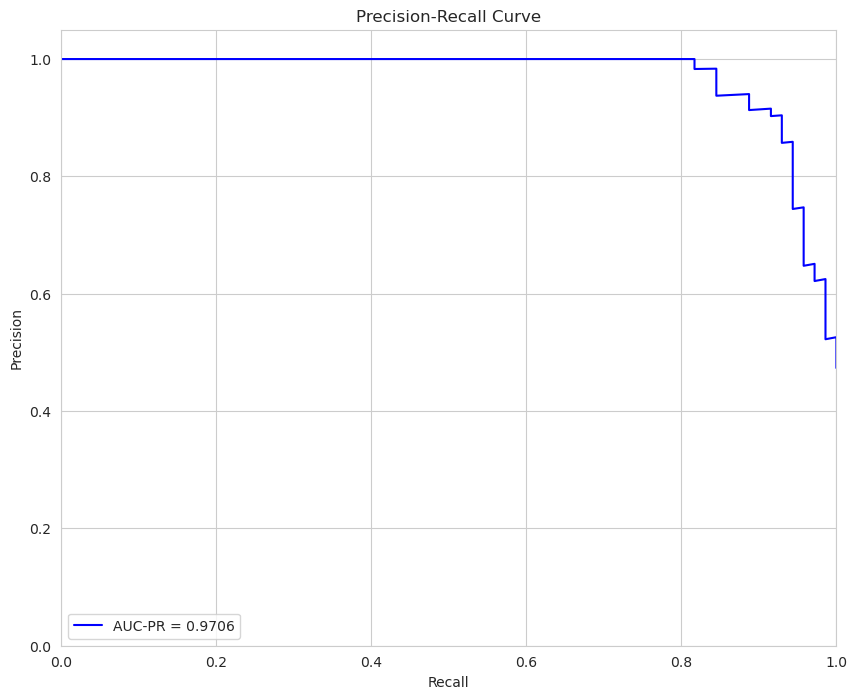

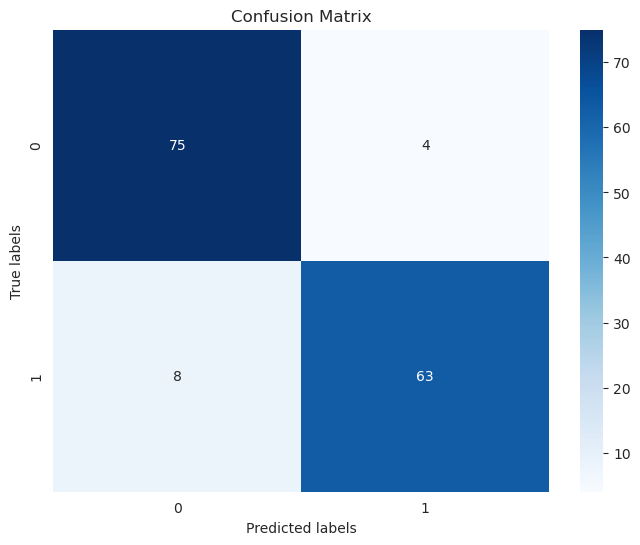

Shape of multi_labels: torch.Size([750, 6])
Shape of multi_labels: torch.Size([250, 6])
Shape of multi_labels: torch.Size([150, 6])
Len of X_train: 750
Starting training...
Epoch 1/100:
Train: Loss=0.2399, Acc=0.9053, Precision=0.9053, Recall=0.9053, F1=0.9053
Validation: Loss=0.1310, Acc=0.9320, Precision=0.9344, Recall=0.9320, F1=0.9313

Epoch 2/100:
Train: Loss=0.1428, Acc=0.9293, Precision=0.9292, Recall=0.9293, F1=0.9292
Validation: Loss=0.0678, Acc=0.9360, Precision=0.9380, Recall=0.9360, F1=0.9354

Epoch 3/100:
Train: Loss=0.1008, Acc=0.9387, Precision=0.9393, Recall=0.9387, F1=0.9388
Validation: Loss=0.0270, Acc=0.9440, Precision=0.9452, Recall=0.9440, F1=0.9436

Epoch 4/100:
Train: Loss=0.0593, Acc=0.9333, Precision=0.9344, Recall=0.9333, F1=0.9335
Validation: Loss=-0.0073, Acc=0.9520, Precision=0.9527, Recall=0.9520, F1=0.9517

Epoch 5/100:
Train: Loss=0.0298, Acc=0.9413, Precision=0.9424, Recall=0.9413, F1=0.9415
Validation: Loss=-0.0371, Acc=0.9520, Precision=0.9527, Recall

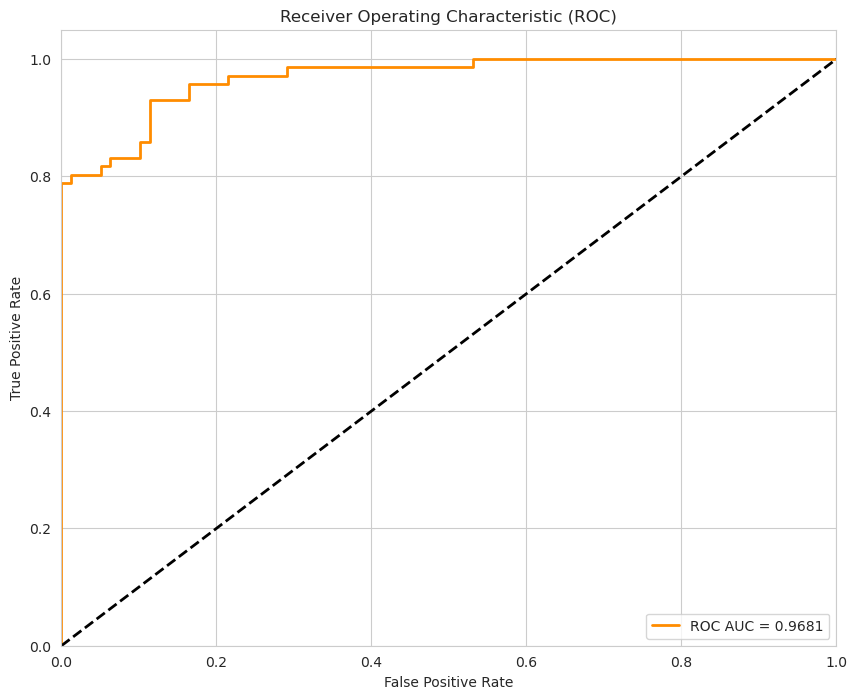

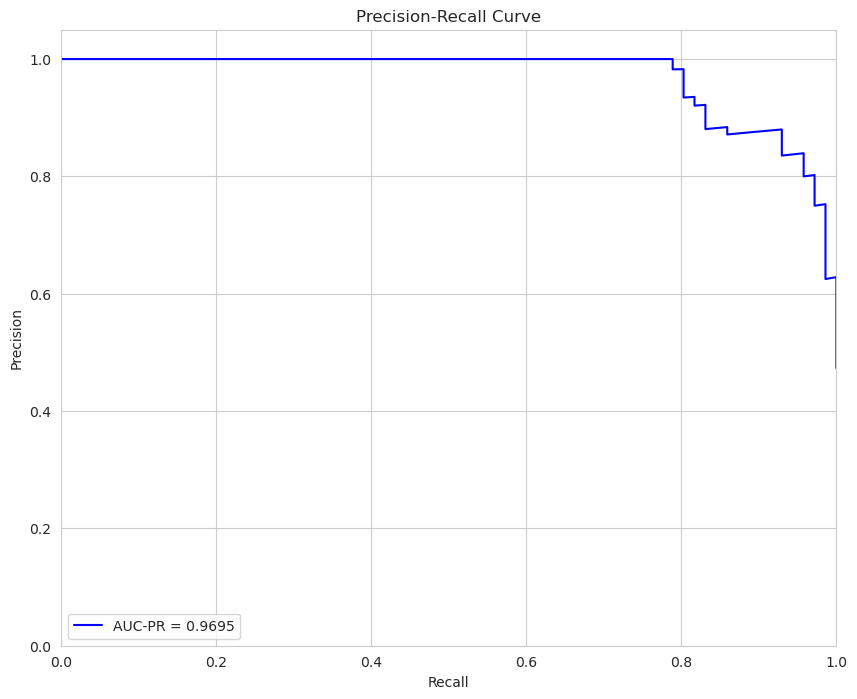

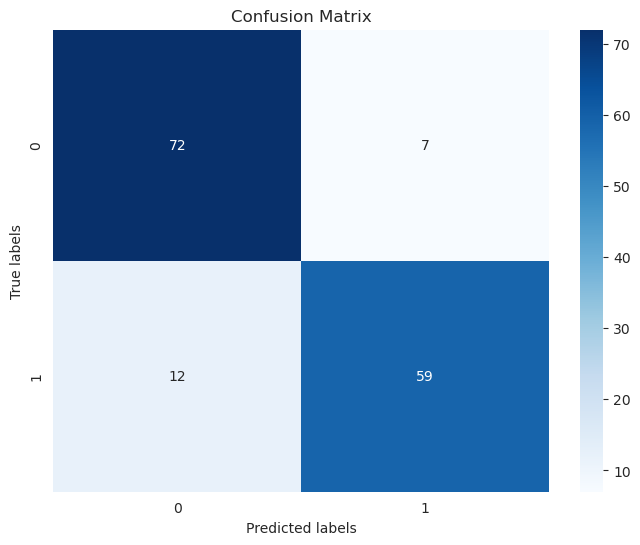

Shape of multi_labels: torch.Size([750, 6])
Shape of multi_labels: torch.Size([250, 6])
Shape of multi_labels: torch.Size([150, 6])
Len of X_train: 750
Starting training...
Epoch 1/100:
Train: Loss=0.4810, Acc=0.6080, Precision=0.6728, Recall=0.6080, F1=0.6025
Validation: Loss=0.4854, Acc=0.4080, Precision=0.4080, Recall=0.4080, F1=0.2365

Epoch 2/100:
Train: Loss=0.4705, Acc=0.6320, Precision=0.6770, Recall=0.6320, F1=0.6316
Validation: Loss=0.4689, Acc=0.4080, Precision=0.4080, Recall=0.4080, F1=0.2365

Epoch 3/100:
Train: Loss=0.4466, Acc=0.6120, Precision=0.6523, Recall=0.6120, F1=0.6123
Validation: Loss=0.4530, Acc=0.4080, Precision=0.4080, Recall=0.4080, F1=0.2365

Epoch 4/100:
Train: Loss=0.4306, Acc=0.6493, Precision=0.6871, Recall=0.6493, F1=0.6503
Validation: Loss=0.4371, Acc=0.4120, Precision=0.7591, Recall=0.4120, F1=0.2451

Epoch 5/100:
Train: Loss=0.4204, Acc=0.6707, Precision=0.7115, Recall=0.6707, F1=0.6713
Validation: Loss=0.4182, Acc=0.4680, Precision=0.7691, Recall=0

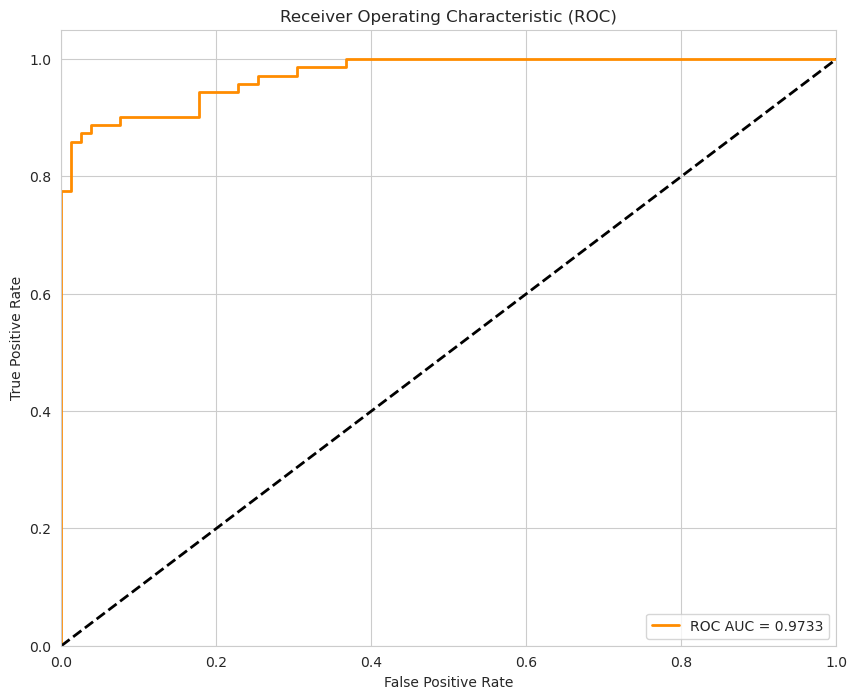

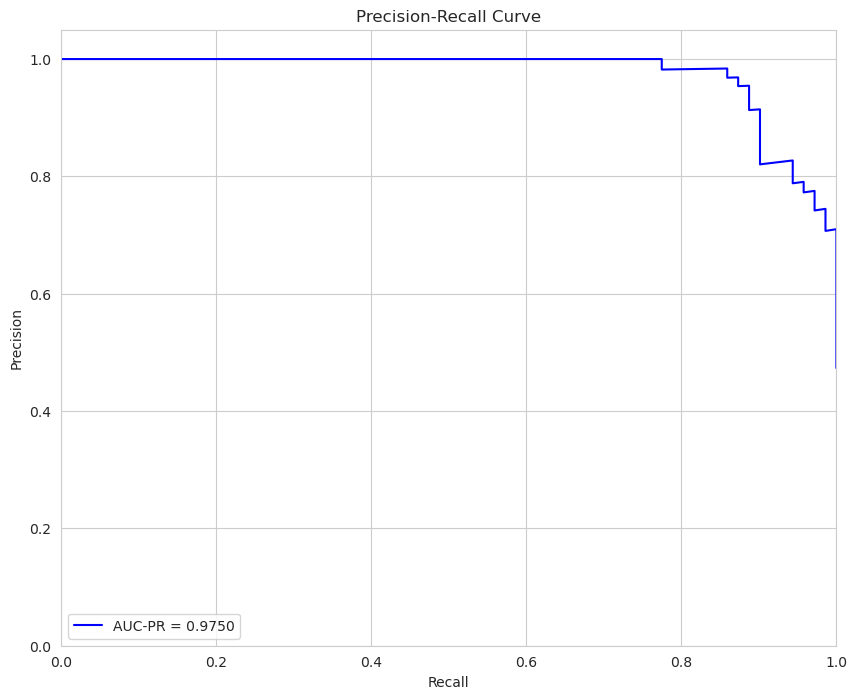

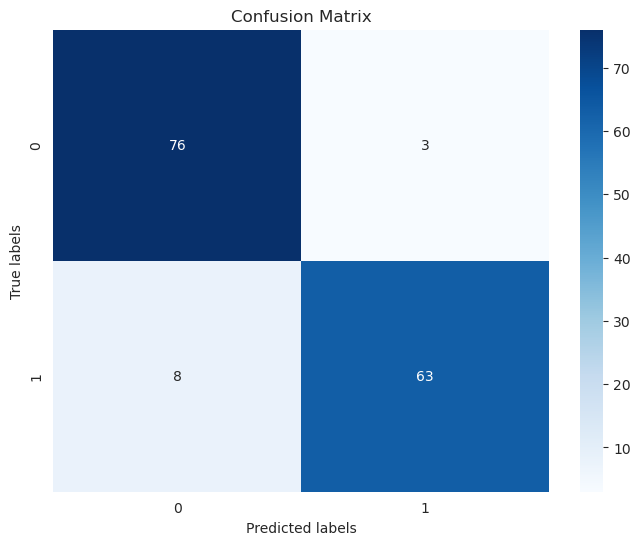

Shape of multi_labels: torch.Size([750, 6])
Shape of multi_labels: torch.Size([250, 6])
Shape of multi_labels: torch.Size([150, 6])
Len of X_train: 750
Starting training...
Epoch 1/100:
Train: Loss=0.6103, Acc=0.4267, Precision=0.5204, Recall=0.4267, F1=0.3242
Validation: Loss=0.4928, Acc=0.4080, Precision=0.4080, Recall=0.4080, F1=0.2365

Epoch 2/100:
Train: Loss=0.5736, Acc=0.4093, Precision=0.4093, Recall=0.4093, F1=0.2378
Validation: Loss=0.4403, Acc=0.4080, Precision=0.4080, Recall=0.4080, F1=0.2365

Epoch 3/100:
Train: Loss=0.5241, Acc=0.4413, Precision=0.7214, Recall=0.4413, F1=0.3079
Validation: Loss=0.3990, Acc=0.5240, Precision=0.7803, Recall=0.5240, F1=0.4517

Epoch 4/100:
Train: Loss=0.4611, Acc=0.6960, Precision=0.7873, Recall=0.6960, F1=0.6899
Validation: Loss=0.3575, Acc=0.8160, Precision=0.8561, Recall=0.8160, F1=0.8169

Epoch 5/100:
Train: Loss=0.4358, Acc=0.7147, Precision=0.7813, Recall=0.7147, F1=0.7125
Validation: Loss=0.3101, Acc=0.8960, Precision=0.9015, Recall=0

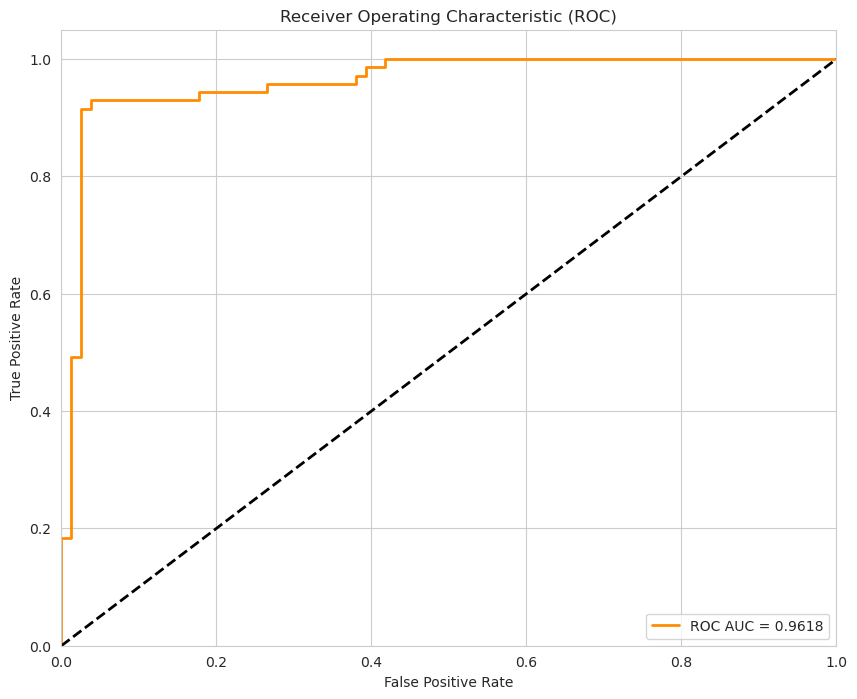

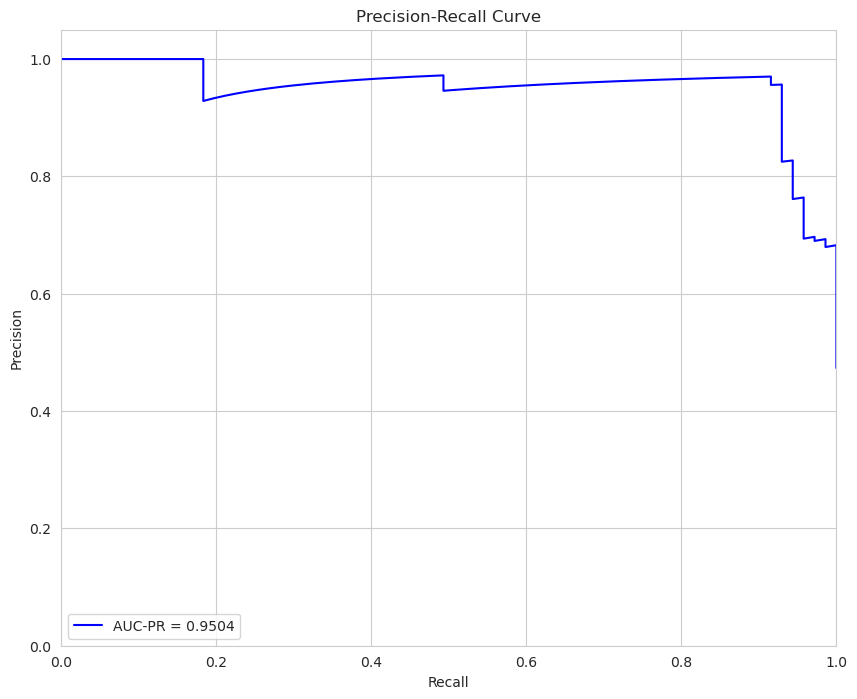

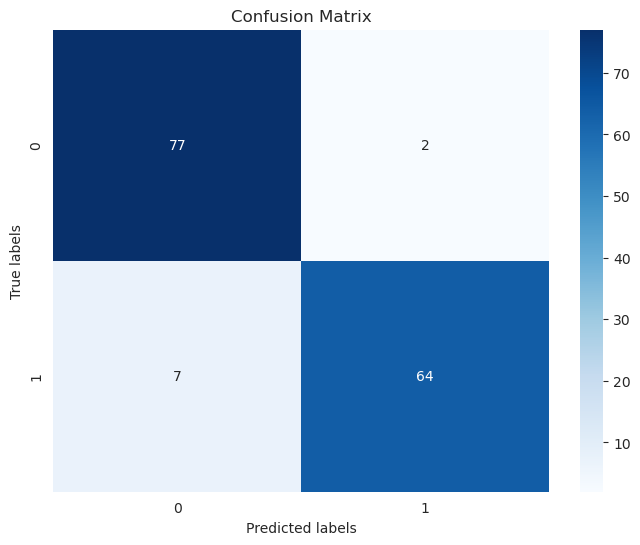

Shape of multi_labels: torch.Size([750, 6])
Shape of multi_labels: torch.Size([250, 6])
Shape of multi_labels: torch.Size([150, 6])
Len of X_train: 750
Starting training...
Epoch 1/100:
Train: Loss=0.3697, Acc=0.8587, Precision=0.8582, Recall=0.8587, F1=0.8583
Validation: Loss=0.2092, Acc=0.9000, Precision=0.9094, Recall=0.9000, F1=0.8976

Epoch 2/100:
Train: Loss=0.3075, Acc=0.8453, Precision=0.8479, Recall=0.8453, F1=0.8460
Validation: Loss=0.1645, Acc=0.9040, Precision=0.9105, Recall=0.9040, F1=0.9021

Epoch 3/100:
Train: Loss=0.2747, Acc=0.8720, Precision=0.8737, Recall=0.8720, F1=0.8724
Validation: Loss=0.1281, Acc=0.9200, Precision=0.9227, Recall=0.9200, F1=0.9191

Epoch 4/100:
Train: Loss=0.2538, Acc=0.8693, Precision=0.8714, Recall=0.8693, F1=0.8698
Validation: Loss=0.1031, Acc=0.9200, Precision=0.9227, Recall=0.9200, F1=0.9191

Epoch 5/100:
Train: Loss=0.1897, Acc=0.8640, Precision=0.8667, Recall=0.8640, F1=0.8646
Validation: Loss=0.0786, Acc=0.9200, Precision=0.9227, Recall=0

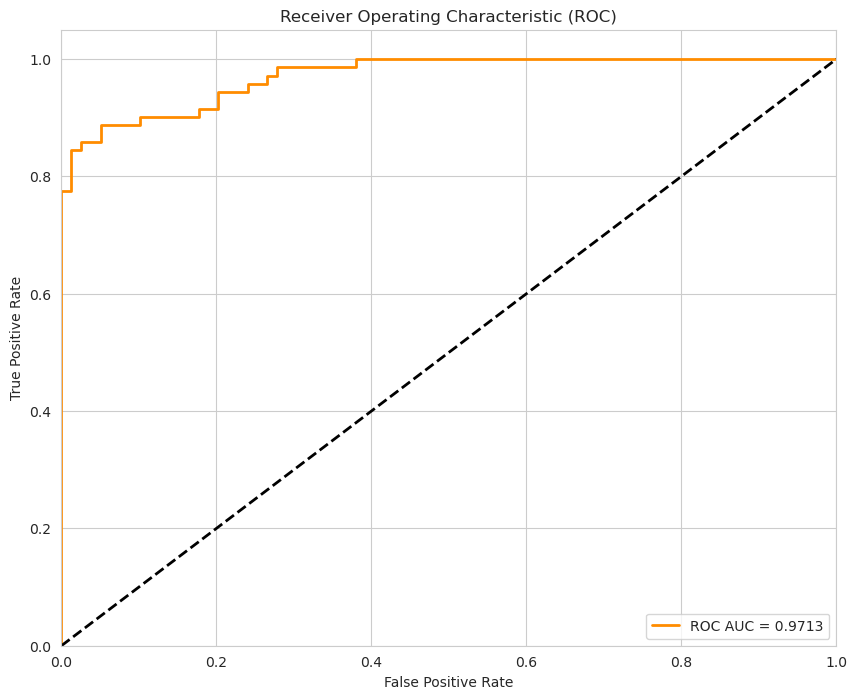

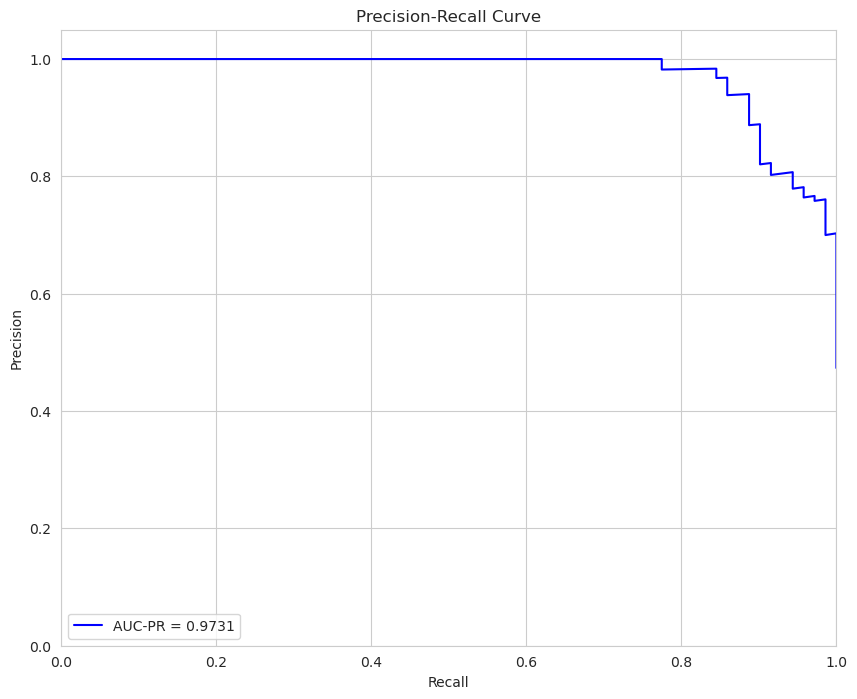

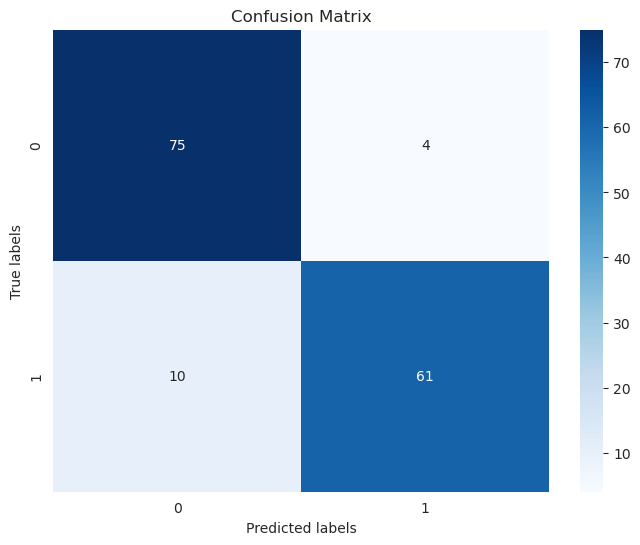

Accuracy: Mean = 0.9133, Std = 0.0227
Precision: Mean = 0.9394, Std = 0.0254
Recall: Mean = 0.8732, Std = 0.0252
F1: Mean = 0.9051, Std = 0.0249
Cohen Kappa: Mean = 0.8255, Std = 0.0457
ROC-AUC: Mean = 0.9674, Std = 0.0046
AUC-PR: Mean = 0.9677, Std = 0.0088


In [11]:
if __name__ == "__main__":
    NUM_CLASSES = 1
    THRESHOLD = 0.5
    SINGLE_LABEL_POS = 0
    USE_LIKELIHOOD = True
    seed_everything(seed=42)

    train_files = ['rsna_train_0_redundancy.csv', 'rsna_train_1_redundancy.csv', 'rsna_train_2_redundancy.csv', 'rsna_train_3_redundancy.csv', 'rsna_train_4_redundancy.csv']
    test_files = ['rsna_test_0_redundancy.csv', 'rsna_test_1_redundancy.csv', 'rsna_test_2_redundancy.csv', 'rsna_test_3_redundancy.csv', 'rsna_test_4_redundancy.csv']
    # train_files = ['rsna_train_0_update.csv', 'rsna_train_1_update.csv', 'rsna_train_2_update.csv', 'rsna_train_3_update.csv', 'rsna_train_4_update.csv']
    # test_files = ['rsna_test_0_update.csv', 'rsna_test_1_update.csv', 'rsna_test_2_update.csv', 'rsna_test_3_update.csv', 'rsna_test_4_update.csv']

    all_results = []
    all_auc_results = []
    all_auc_pr_results = []
    for train_file, test_file in zip(train_files, test_files):
        train_file = f'author_data/{train_file}'
        test_file = f'author_data/{test_file}'
        results = main(train_file, test_file, num_instances=28, learning_rate=0.00005, batch_size=16, num_epochs=100, use_likelihood=USE_LIKELIHOOD)
        all_results.append(results[:5])
        all_auc_results.append(results[5])
        all_auc_pr_results.append(results[6])

    # Calculate and print mean and std for scalar metrics
    all_results = np.array(all_results)
    mean_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Cohen Kappa']
    for i, metric in enumerate(metrics):
        print(f'{metric}: Mean = {mean_results[i]:.4f}, Std = {std_results[i]:.4f}')

    # Handle AUC metrics separately
    if NUM_CLASSES == 1:
        print(f'ROC-AUC: Mean = {np.mean(all_auc_results):.4f}, Std = {np.std(all_auc_results):.4f}')
        print(f'AUC-PR: Mean = {np.mean(all_auc_pr_results):.4f}, Std = {np.std(all_auc_pr_results):.4f}')
    else:
        # For multi-class, you might want to average across classes first
        mean_auc = np.mean([np.mean(auc) for auc in all_auc_results])
        std_auc = np.std([np.mean(auc) for auc in all_auc_results])
        mean_auc_pr = np.mean([np.mean(auc_pr) for auc_pr in all_auc_pr_results])
        std_auc_pr = np.std([np.mean(auc_pr) for auc_pr in all_auc_pr_results])
        print(f'ROC-AUC: Mean = {mean_auc:.4f}, Std = {std_auc:.4f}')
        print(f'AUC-PR: Mean = {mean_auc_pr:.4f}, Std = {std_auc_pr:.4f}')

# Visualization